# Face Detection Pipeline: Image Features Application

Based on Chapter 5 from *Python for Data Science Handbook*, by Jake VanderPlas.

This chapter has explored a number of the central concepts and algorithms of machine learning.
But moving from these concepts to real-world application can be a challenge.
Real-world datasets are noisy and heterogeneous, may have missing features, and data may be in a form that is difficult to map to a clean ``[n_samples, n_features]`` matrix.
Before applying any of the methods discussed here, you must first extract these features from your data: there is no formula for how to do this that applies across all domains, and thus this is where you as a data scientist must exercise your own intuition and expertise.

One interesting and compelling application of machine learning is to images, and we have already seen a few examples of this where pixel-level features are used for classification.
In the real world, data is rarely so uniform and simple pixels will not be suitable: this has led to a large literature on *feature extraction* methods for image data.

In this section, we will take a look at one such feature extraction technique, the [Histogram of Oriented Gradients](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) (HOG), which transforms image pixels into a vector representation that is sensitive to broadly informative image features regardless of confounding factors like illumination.
We will use these features to develop a simple face detection pipeline, using machine learning algorithms and concepts we've seen throughout this chapter. 

We begin with the standard imports:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings("ignore")

##  Histogram of Oriented Gradients (HOG) Features

The Histogram of Gradients is a straightforward feature extraction procedure that was developed in the context of identifying pedestrians within images.
HOG involves the following steps:

1. Optionally pre-normalize images. This leads to features that resist dependence on variations in illumination.
2. Convolve the image with two filters that are sensitive to horizontal and vertical brightness gradients. These capture edge, contour, and texture information.
3. Subdivide the image into cells of a predetermined size, and compute a histogram of the gradient orientations within each cell.
4. Normalize the histograms in each cell by comparing to the block of neighboring cells. This further suppresses the effect of illumination across the image.
5. Construct a one-dimensional feature vector from the information in each cell.

A fast HOG extractor is built into the Scikit-Image project, and we can try it out relatively quickly and visualize the oriented gradients within each cell:

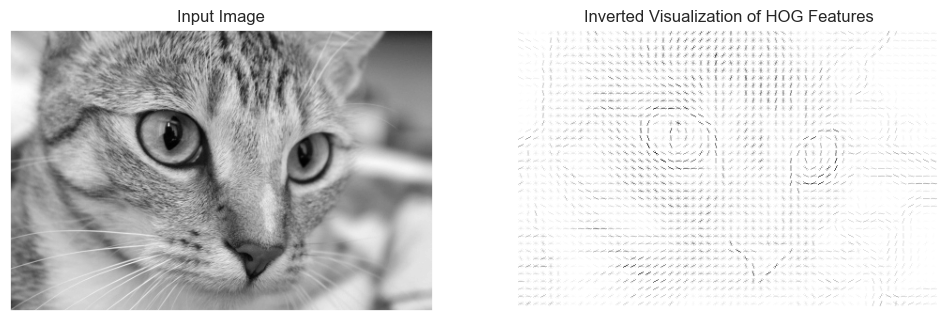

In [2]:
from skimage import data, color, feature
import matplotlib.pyplot as plt
import numpy as np

# Load the example image and convert it to grayscale
image = color.rgb2gray(data.chelsea())                 # Use the 'chelsea' image and convert to grayscale

# Compute HOG (Histogram of Oriented Gradients) features and the visualization
hog_vec, hog_vis = feature.hog(image, visualize=True)  # Note: 'visualize' is the correct argument

# Invert the HOG visualization
hog_vis_inverted = np.max(hog_vis) - hog_vis           # Invert the image by subtracting from the max value

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(xticks=[], yticks=[]))

# Display the input image in the first subplot
ax[0].imshow(image, cmap='gray')  # Show the grayscale image
ax[0].set_title('Input Image')    # Set the title for the first subplot

# Display the inverted HOG visualization in the second subplot
ax[1].imshow(hog_vis_inverted, cmap='gray')                # Show the inverted HOG visualization
ax[1].set_title('Inverted Visualization of HOG Features')  # Set the title for the second subplot

plt.show();

## HOG in Action: A Simple Face Detector

Using these HOG features, we can build up a simple facial detection algorithm with any Scikit-Learn estimator; here we will use a linear support vector machine if you need a refresher on this).
The steps are as follows:

1. Obtain a set of image thumbnails of faces to constitute "positive" training samples.
2. Obtain a set of image thumbnails of non-faces to constitute "negative" training samples.
3. Extract HOG features from these training samples.
4. Train a linear SVM classifier on these samples.
5. For an "unknown" image, pass a sliding window across the image, using the model to evaluate whether that window contains a face or not.
6. If detections overlap, combine them into a single window.

Let's go through these steps and try it out:

### 1. Obtain a set of positive training samples

Let's start by finding some positive training samples that show a variety of faces.
We have one easy set of data to work with—the Labeled Faces in the Wild dataset, which can be downloaded by Scikit-Learn:

In [3]:
# Import the function to fetch the LFW (Labeled Faces in the Wild) people dataset
from sklearn.datasets import fetch_lfw_people

# Fetch the LFW people dataset
faces = fetch_lfw_people()

# Extract the images from the dataset
positive_patches = faces.images

# Print the shape of the images array
positive_patches.shape  # This shows the dimensions of the dataset (number of images, height, width)

(13233, 62, 47)

This gives us a sample of 13,000 face images to use for training.

### 2. Obtain a set of negative training samples

Next we need a set of similarly sized thumbnails which *do not* have a face in them.
One way to do this is to take any corpus of input images, and extract thumbnails from them at a variety of scales.
Here we can use some of the images shipped with Scikit-Image, along with Scikit-Learn's ``PatchExtractor``:

In [4]:
# Import necessary modules from skimage
from skimage import data, color

# List of image names to use from the skimage data module
imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']

# Initialize an empty list to hold the images
images = []

# Loop over the list of image names
for name in imgs_to_use:
    
    img = getattr(data, name)()              # Get the image from the data module using the name
    
    if len(img.shape) == 2:                  # Check if the image is already grayscale       
        images.append(img)                   # If the image is grayscale, append it directly
    else:      
        images.append(color.rgb2gray(img))   # If the image is not grayscale, convert it to grayscale

# Print out the shapes of the loaded images to verify
for i, img in enumerate(images):
    print(f"Image {imgs_to_use[i]} shape: {img.shape}")

# Now 'images' contains the grayscale versions of the specified images

Image camera shape: (512, 512)
Image text shape: (172, 448)
Image coins shape: (303, 384)
Image moon shape: (512, 512)
Image page shape: (191, 384)
Image clock shape: (300, 400)
Image immunohistochemistry shape: (512, 512)
Image chelsea shape: (300, 451)
Image coffee shape: (400, 600)
Image hubble_deep_field shape: (872, 1000)


In [5]:
# Import the necessary module for patch extraction
from sklearn.feature_extraction.image import PatchExtractor
from skimage import transform

# Define a function to extract patches from an image
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    """
    Extract patches from an image.
    
    Parameters:
    img (ndarray): The input image from which patches will be extracted.
    N (int): The number of patches to extract.
    scale (float): The scaling factor for the patch size.
    patch_size (tuple): The size of the patches to extract.
    
    Returns:
    patches (ndarray): An array of extracted patches.
    """
    # Calculate the size of the patches to extract based on the scale
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    
    # Create a PatchExtractor object with the specified patch size and number of patches
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    
    # Extract patches from the image; np.newaxis adds an extra dimension to the image
    patches = extractor.transform(img[np.newaxis])
    
    # If the scale is not 1, resize the patches to the original patch size
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    
    # Return the extracted patches
    return patches

# Extract negative patches from a list of images at different scales and concatenate them
negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])

# Print the shape of the negative patches array
negative_patches.shape

(30000, 62, 47)

We now have 30,000 suitable image patches which do not contain faces. Let's take a look at a few of them to get an idea of what they look like:

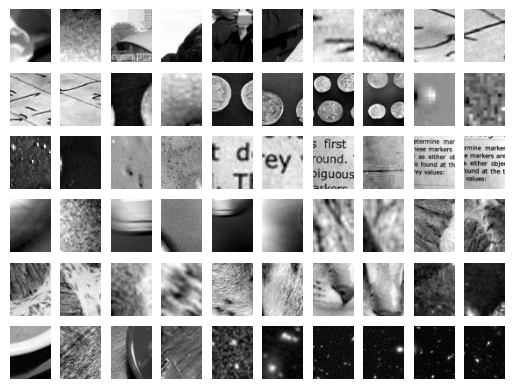

In [6]:
# Create a figure with a grid of 6 rows and 10 columns of subplots
fig, ax = plt.subplots(6, 10)

# Iterate over each subplot and its index in a flattened version of the grid
for i, axi in enumerate(ax.flat):
    # Display the negative patch at the specified index (500 * i) in grayscale
    axi.imshow(negative_patches[500 * i], cmap='gray')
    
    # Turn off the axis to hide the ticks and labels
    axi.axis('off')

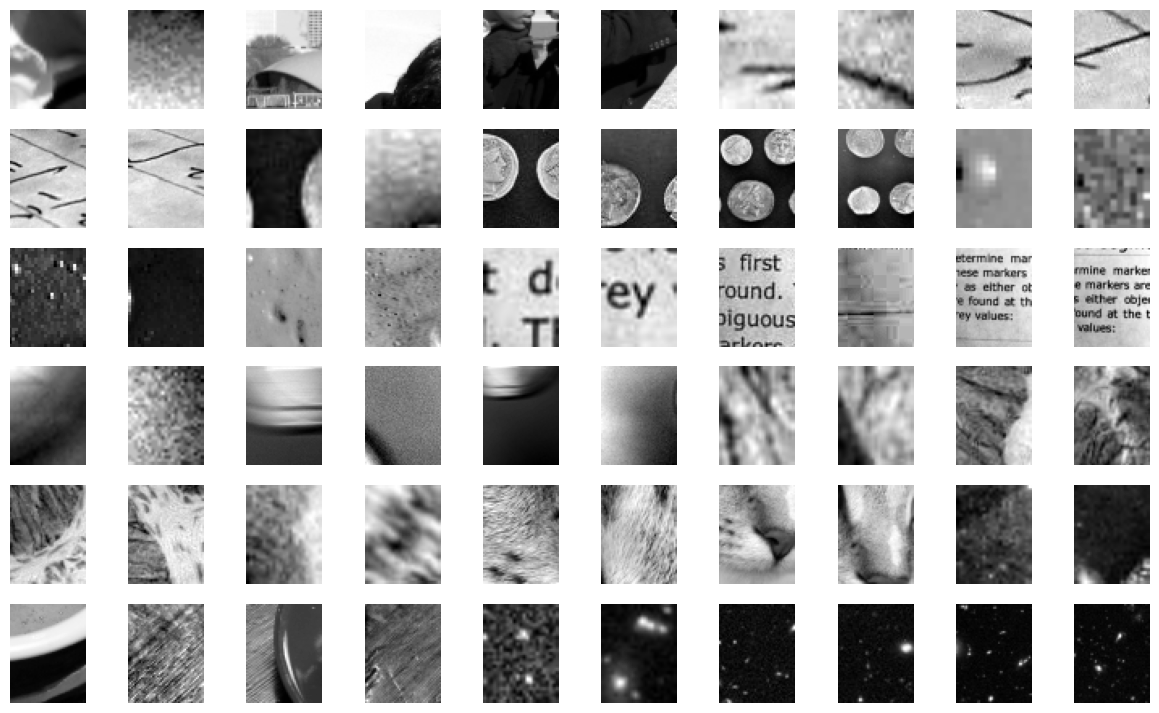

In [7]:
# Create a figure with a grid of 6 rows and 10 columns of subplots, and increase the figure size
fig, ax = plt.subplots(6, 10, figsize=(15, 9))

# Iterate over each subplot and its index in a flattened version of the grid
for i, axi in enumerate(ax.flat):
    
    axi.imshow(negative_patches[500 * i], cmap='gray')  # Display the negative patch at the specified index (500 * i) in grayscale
    
    axi.axis('off')                                     # Turn off the axis to hide the ticks and labels

# Display the figure
plt.show()

Our hope is that these would sufficiently cover the space of "non-faces" that our algorithm is likely to see.

### 3. Combine sets and extract HOG features

Now that we have these positive samples and negative samples, we can combine them and compute HOG features.
This step takes a little while, because the HOG features involve a nontrivial computation for each image:

In [8]:
from itertools import chain
from skimage import feature

# Flatten the list of positive and negative patches and compute HOG features for each patch
X_train = np.array([feature.hog(im)                    # Compute the Histogram of Oriented Gradients (HOG) feature vector for each image
                    for im in chain(positive_patches,  # Combine positive and negative patches into a single iterable
                                    negative_patches)])

# Create an array of labels for the training data
y_train = np.zeros(X_train.shape[0])     # Initialize all labels to 0 (for negative patches)
y_train[:positive_patches.shape[0]] = 1  # Set labels for positive patches to 1

# Print the shape of the training feature matrix
X_train.shape

(43233, 1215)

We are left with 43,000 training samples in 1,215 dimensions, and we now have our data in a form that we can feed into Scikit-Learn!

### 4. Training a support vector machine

Next we use the tools we have been exploring in this chapter to create a classifier of thumbnail patches.
For such a high-dimensional binary classification task, a Linear support vector machine is a good choice.
We will use Scikit-Learn's ``LinearSVC``, because in comparison to ``SVC`` it often has better scaling for large number of samples.

First, though, let's use a simple Gaussian naive Bayes to get a quick baseline:

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score  # Updated import for cross-validation function

# Perform cross-validation to evaluate the performance of Gaussian Naive Bayes classifier
scores = cross_val_score(GaussianNB(),  # Initialize Gaussian Naive Bayes classifier
                         X_train,       # Feature matrix
                         y_train)       # Labels

# Print cross-validation scores
print(scores)

[0.95732624 0.972476   0.97340118 0.97628961 0.97490169]


We see that on our training data, even a simple naive Bayes algorithm gets us upwards of 90% accuracy. Let's try the support vector machine, with a grid search over a few choices of the C parameter:

In [10]:
from sklearn.svm import LinearSVC                 # Import Linear Support Vector Classification
from sklearn.model_selection import GridSearchCV  # Import GridSearchCV for hyperparameter tuning

# Initialize GridSearchCV with LinearSVC and a range of C values to search
grid = GridSearchCV(LinearSVC(),                  # The model to tune
                    {'C': [1.0, 2.0, 4.0, 8.0]})  # The hyperparameter grid to search

# Fit GridSearchCV on the training data to find the best hyperparameters
grid.fit(X_train, y_train)

# Output the best cross-validation score obtained
print(grid.best_score_)

0.9885503967913524


In [11]:
# Output the best hyperparameters found
print("Best parameters:", grid.best_params_)

Best parameters: {'C': 1.0}


Let's take the best estimator and re-train it on the full dataset:

In [12]:
# Retrieve the best model from the grid search
model = grid.best_estimator_

# Fit the best model on the entire training dataset
model.fit(X_train, y_train)

LinearSVC()

### 5. Find faces in a new image

Now that we have this model in place, let's grab a new image and see how the model does.
We will use one portion of the astronaut image for simplicity, and run a sliding window over it and evaluate each patch:

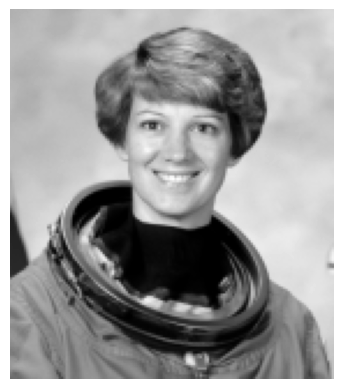

In [13]:
import skimage.data
import skimage.color
import skimage.transform

# Load and preprocess the test image
test_image = skimage.data.astronaut()                    # Load the astronaut image
test_image = skimage.color.rgb2gray(test_image)          # Convert to grayscale
test_image = skimage.transform.rescale(test_image, 0.5)  # Rescale to 50% of original size
test_image = test_image[:160, 40:180]                    # Crop the image to desired region

# Display the test image
plt.imshow(test_image, cmap='gray')  # Show image in grayscale
plt.axis('off')                      # Remove axis
plt.show()                           # Display the plot

Next, let's create a window that iterates over patches of this image, and compute HOG features for each patch:

In [14]:
from skimage import transform, feature
import numpy as np

def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    """
    Generate patches from an image using a sliding window approach.
    
    Parameters:
    - img: 2D array, the input image.
    - patch_size: tuple, the size of the patches to extract.
    - istep: int, the step size in the vertical direction.
    - jstep: int, the step size in the horizontal direction.
    - scale: float, the scaling factor for patch size.
    
    Yields:
    - (i, j): tuple, the top-left corner coordinates of the patch.
    - patch: 2D array, the extracted patch.
    """
    # Compute the dimensions of the patches considering the scale
    Ni, Nj = (int(scale * s) for s in patch_size)
    
    # Iterate over the image with specified step sizes
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Nj, jstep):
            
            patch = img[i:i + Ni, j:j + Nj]    # Extract the patch from the image
            
            if scale != 1:                     # Resize the patch if scaling is applied
                patch = transform.resize(patch, patch_size)
            
            yield (i, j), patch                # Yield the top-left coordinates and the patch
            
# Apply the sliding window to the test image
indices, patches = zip(*sliding_window(test_image))

# Compute the HOG (Histogram of Oriented Gradients) features for each patch
patches_hog = np.array([feature.hog(patch) for patch in patches])

# Output the shape of the HOG features array
patches_hog.shape

(2303, 1215)

Finally, we can take these HOG-featured patches and use our model to evaluate whether each patch contains a face:

In [15]:
# Predict labels for each patch based on the trained model
labels = model.predict(patches_hog)

# Sum of predicted labels
# This will give the total count of patches classified as the positive class (label = 1)
labels_sum = labels.sum()

# Output the sum of the predicted labels
labels_sum

44.0

We see that out  2,300 patches, we have found 44 detections.
Let's use the information we have about these patches to show where they lie on our test image, drawing them as rectangles:

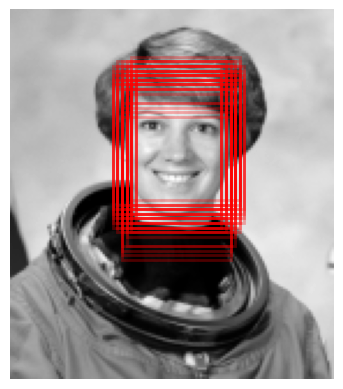

In [16]:
# Create a figure and axis for plotting
fig, ax = plt.subplots()

# Display the test image in grayscale
ax.imshow(test_image, cmap='gray')

# Turn off the axis
ax.axis('off')

# Extract patch size from the shape of a positive patch
Ni, Nj = positive_patches[0].shape

# Convert indices to a NumPy array
indices = np.array(indices)

# Loop over the indices of patches classified as positive
for i, j in indices[labels == 1]:
    # Add a rectangle patch for each positive detection
    ax.add_patch(plt.Rectangle(
        (j, i),           # Top-left corner (x, y)
        Nj,               # Width of the rectangle
        Ni,               # Height of the rectangle
        edgecolor='red',  # Color of the rectangle's border
        alpha=0.3,        # Transparency of the rectangle
        lw=2,             # Line width of the rectangle's border
        facecolor='none'  # No fill color inside the rectangle
    ))

# Show the plot
plt.show()

All of the detected patches overlap and found the face in the image!
Not bad for a few lines of Python.

## Caveats and Improvements

If you dig a bit deeper into the preceding code and examples, you'll see that we still have a bit of work before we can claim a production-ready face detector.
There are several issues with what we've done, and several improvements that could be made. In particular:

### Our training set, especially for negative features, is not very complete

The central issue is that there are many face-like textures that are not in the training set, and so our current model is very prone to false positives.
You can see this if you try out the above algorithm on the *full* astronaut image: the current model leads to many false detections in other regions of the image.

We might imagine addressing this by adding a wider variety of images to the negative training set, and this would probably yield some improvement.
Another way to address this is to use a more directed approach, such as *hard negative mining*.
In hard negative mining, we take a new set of images that our classifier has not seen, find all the patches representing false positives, and explicitly add them as negative instances in the training set before re-training the classifier.

### Our current pipeline searches only at one scale

As currently written, our algorithm will miss faces that are not approximately 62×47 pixels.
This can be straightforwardly addressed by using sliding windows of a variety of sizes, and re-sizing each patch using ``skimage.transform.resize`` before feeding it into the model.
In fact, the ``sliding_window()`` utility used here is already built with this in mind.

### We should combine overlapped detection patches

For a production-ready pipeline, we would prefer not to have 30 detections of the same face, but to somehow reduce overlapping groups of detections down to a single detection.
This could be done via an unsupervised clustering approach (MeanShift Clustering is one good candidate for this), or via a procedural approach such as *non-maximum suppression*, an algorithm common in machine vision.

### The pipeline should be streamlined

Once we address these issues, it would also be nice to create a more streamlined pipeline for ingesting training images and predicting sliding-window outputs.
This is where Python as a data science tool really shines: with a bit of work, we could take our prototype code and package it with a well-designed object-oriented API that give the user the ability to use this easily.
I will leave this as a proverbial "exercise for the reader".

### More recent advances: Deep Learning

Finally, I should add that HOG and other procedural feature extraction methods for images are no longer state-of-the-art techniques.
Instead, many modern object detection pipelines use variants of deep neural networks: one way to think of neural networks is that they are an estimator which determines optimal feature extraction strategies from the data, rather than relying on the intuition of the user.
An intro to these deep neural net methods is conceptually (and computationally!) beyond the scope of this section, although open tools like Google's [TensorFlow](https://www.tensorflow.org/) have recently made deep learning approaches much more accessible than they once were.
As of the writing of this book, deep learning in Python is still relatively young, and so I can't yet point to any definitive resource.
That said, the list of references in the following section should provide a useful place to start!